# Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.  
Требуется проанализировать собранные данные и построить на их основе модель машинного обучения, предсказывающую возможность расторжения договора клиентом.

Целевое значение метрики: AUC-ROC=0.85.

## Загрузка и предобработка данных

Импортируем необходимые библиотеки и функции:

In [1]:
pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.9 MB 1.4 MB/s 
     |████████████████████████████████| 596 kB 5.2 MB/s 
     |████████████████████████████████| 102 kB 43.1 MB/s 
     |████████████████████████████████| 690 kB 36.7 MB/s 
     |████████████████████████████████| 4.7 MB 14.6 MB/s 
     |████████████████████████████████| 62 kB 589 kB/s 
     |████████████████████████████████| 812 kB 51.8 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=261257 sha256=e32971647367989f2e0143ae4b81a5ca7a6ba3742671af129836166fa5234338
  Stored in directory: /tmp/pip-ephem-wheel-cache-uynsg0rd/wheels/c3/aa/10/94ee985ca5a122f047c430cf991df62fe210c4789d3b5762a5
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=0d7cb223d22110f1e2bc95304aecb9ccc58a6b6beb3450a10fa912e0b8ebcc8b
  Stored in directory: /root/.cache/pip/whee

In [2]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from pandas_profiling import ProfileReport

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from catboost import cv, Pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

Загрузим данные из папки /datasets/final_provider/ и выведем на экран основную информацию:

### Таблица с информацией о договорах клиентов

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_contract = pd.read_csv('/content/drive/My Drive/Colab Notebooks/contract.csv')

In [6]:
pd.options.display.max_columns = None
data_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [7]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Датафрейм состоит из 7043 строк с данными о договорах клиентов и 8 столбцов, в которых указаны:

- customerID — id клиента  


- BeginDate — дата заключения договора. Тип данных 'object'- требуется замена на 'datetime'  


- EndDate — дата расторжения договора или 'No' для действующих договоров. Даты представлены строками, тип данных 'object'- требуется замена на 'datetime'  


- Type — тип оплаты услуг (каждый месяц или заключен договор на 1–2 года)  


- PaperlessBilling — счет предоставляется электронным методом  


- PaymentMethod — способ оплаты  


- MonthlyCharges — ежмесячная оплата, поступающая от клиента  


- TotalCharges — общая сумма оплаты, поступившая от клиента, тип данных 'object'- требуется замена на 'float'

Проверим значения в столбце 'TotalCharges':

In [8]:
data_contract['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

В столбце есть 11 пустых ячеек, которые необходимо предварительно заполнить нулями (решение по их дальнейшей обработке примем позже), а также привести все данные в столбце к типу float:

In [9]:
data_contract['TotalCharges'] = data_contract['TotalCharges'].replace(" ", 0).astype('float64')

In [10]:
data_contract.info() # проверка преобразования

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Проверим, нет ли в столбце 'TotalCharges' иных нулевых значений, кроме тех 11, что добавили мы:

In [11]:
data_contract[data_contract['TotalCharges'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0


Других нулевых значений в столбце нет.

Известно, что датафрейм выгружался из базы данных 01.02.2020. В этот день данные могли быть выгружены некорректно. Проверим данную конкретную дату, найдя её в столбцах 'BeginDate' или	'EndDate':

In [12]:
data_contract[data_contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0


В столбце 'BeginDate' есть дата заключения договора 01.02.2020 - это те же самые 11 строк, в которых были пустые ячейки, заполненные нами нулями.

Проверим уникальные значения в столбце 'EndDate':

In [13]:
data_contract['EndDate'].sort_values().unique()

array(['2019-10-01 00:00:00', '2019-11-01 00:00:00',
       '2019-12-01 00:00:00', '2020-01-01 00:00:00', 'No'], dtype=object)

In [14]:
data_contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

**ВАЖНО!** Клиенты начали активно расторгать договоры с октября 2019 года. До 01.10.2019 нет ни одного расторгнутого договора.

Для цели дальнейшего обучения модели создадим целевой признак - столбец 'Cancelled', в котором значение 1 соотвествует расторгнутому договору, а значение 0 - действующему.

In [15]:
data_contract['Cancelled'] = np.where(data_contract['EndDate'] == 'No', 0, 1)

Проверим какую долю составляют расторгнутые договоры среди заключенных 1-3 месяца назад:

In [16]:
data_contract['Cancelled'][data_contract['BeginDate'] >= '2019-11-01'].mean()

0.33666191155492153

**ВАЖНО!** Более трети (33,7%) всех новых, заключенных с ноября 2019 года договоров расторгнуто. В компании имеет место массовый отток клиентов. Требуется повышенное внимание к данной проблеме.

Приводим дату начала договора к типу даты

In [17]:
data_contract['BeginDate'] = pd.to_datetime(data_contract['BeginDate'], format='%Y-%m-%d')

Для дальнейшего расчета срока действия договора заменим значение "No" в столбце 'EndDate' на дату 01.02.2020 - дату выгрузки базы:

In [18]:
data_contract['EndDate'] = np.where(data_contract['EndDate'] == 'No', '2020-02-01', data_contract['EndDate'])

Приводим дату конца срока действия договора к типу даты

In [19]:
data_contract['EndDate'] = pd.to_datetime(data_contract['EndDate'], format='%Y-%m-%d')

In [20]:
data_contract.head(20) # визуальная проверка выполненных преобразований

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cancelled
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,1
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,0
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,0


Вычислим продолжительность договора в днях, добавляя новый столбец 'Duration'. Не забудем +1 день (договор, заключенный вчера и расторгнутй сегодня, считается действующим 2 дня).

In [21]:
data_contract['Duration'] = (data_contract['EndDate'] - data_contract['BeginDate']).dt.components['days'] +1

Проверим, как выглядят контракты, заключенные 2 месяца назад (от даты выгрузки) на 1 год:

In [22]:
data_contract[(data_contract['BeginDate'] == '2019-12-01') & (data_contract['Type'] == 'One year')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cancelled,Duration
601,5173-ZXXXL,2019-12-01,2020-02-01,One year,No,Mailed check,19.95,47.70,0,63
720,4697-LUPSU,2019-12-01,2020-02-01,One year,No,Mailed check,20.20,34.75,0,63
3475,8610-ZIKJJ,2019-12-01,2020-02-01,One year,No,Mailed check,20.30,31.90,0,63
3827,6870-ECSHE,2019-12-01,2020-02-01,One year,No,Mailed check,20.45,34.80,0,63
6159,5857-XRECV,2019-12-01,2020-02-01,One year,No,Bank transfer (automatic),20.50,38.25,0,63


Проверим, как выглядят контракты, заключенные 2 месяца назад и менее (от даты выгрузки) с типом оплаты 'Month-to-month':

In [23]:
data_contract[(data_contract['BeginDate'] >= '2019-12-01') & (data_contract['Type'] == 'Month-to-month')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cancelled,Duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,32
31,4929-XIHVW,2019-12-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),95.50,181.65,0,63
33,7310-EGVHZ,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),20.20,20.20,0,32
34,3413-BMNZE,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),45.25,45.25,0,32
46,5948-UJZLF,2019-12-01,2020-02-01,Month-to-month,No,Mailed check,49.25,97.00,0,63
...,...,...,...,...,...,...,...,...,...,...
6877,4501-EQDRN,2019-12-01,2020-01-01,Month-to-month,No,Bank transfer (automatic),69.70,69.70,1,32
6909,9108-EJFJP,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,53.55,53.55,0,32
6979,5351-QESIO,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,24.20,24.20,0,32
7016,1471-GIQKQ,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,49.95,49.95,0,32


По двум выведенным выше таблицам можно обратить внимание на то, что значение MonthlyCharges, умноженное на количество месяцев более 1 (в нашем случае на 2) не равно значению TotalCharges. Причём возможно отклонение как в большую сторону, так и в меньшую.  
Это говорит о том, что информация о тарификации, предоставленная заказчиком - неполная. Возможно запросить заказчика о пояснении формирования данных в столбце MonthlyCharges.

В ожидании ответа заказчика вычислим размер ежедневных расходов клиента на связь и интенет, добавляя новый столбец 'Charges_per_day'.

In [24]:
data_contract['Charges_per_day'] = data_contract['TotalCharges'] / data_contract['Duration']

In [25]:
data_contract # проверка

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cancelled,Duration,Charges_per_day
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,32,0.932813
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1037,1.822083
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,62,1.744355
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1372,1.341655
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,62,2.445968
...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,731,2.722982
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2192,3.358987
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,338,1.025000
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,124,2.472581


Данные готовы для дальнейшего анализа, который будет проведён в Разделе 3.

### Таблица с персональными данными клиентов

In [26]:
data_personal = pd.read_csv('/content/drive/My Drive/Colab Notebooks/personal.csv')

In [27]:
data_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [28]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [29]:
data_personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [30]:
data_personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [31]:
data_personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [32]:
data_personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

Датафрейм состоит из 7043 строк с персональными данными клиентов и 5 столбцов, в которых указаны:

- customerID — id клиента  


- gender — пол клиента  


- SeniorCitizen — принадлежность клиента к категории "Пожилой абонент"  


- Partner — наличие у клиента супруги/супруга  


- Dependents — наличие у клиента детей/иждивенцев


В таблице пропусков и некорректных значений нет. Данные готовы для дальнейшего анализа.

### Таблица с информацией об интернет-услугах

In [33]:
data_internet = pd.read_csv('/content/drive/My Drive/Colab Notebooks/internet.csv')

In [34]:
data_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [35]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [36]:
data_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [37]:
data_internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [38]:
data_internet['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [39]:
data_internet['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [40]:
data_internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [41]:
data_internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [42]:
data_internet['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

Датафрейм состоит из 5517 строк с персональными данными клиентов и 8 столбцов, в которых указаны:

- customerID — id клиента  


- InternetService — тип интернет-подключения  


- OnlineSecurity — наличие блокировки небезопасных сайтов 


- OnlineBackup — наличие облачного хранилища файлов для резервного копирования данных  


- DeviceProtection — наличие антивируса  


- TechSupport — наличие выделенной линии технической поддержки  


- StreamingTV — наличие стримингого телевидения  


- StreamingMovies — наличие каталога фильмов  


В таблице пропусков и некорректных значений нет. Данные готовы для дальнейшего анализа.

### Таблица с информацией об услугах телефонии

In [43]:
data_phone = pd.read_csv('/content/drive/My Drive/Colab Notebooks/phone.csv')

In [44]:
data_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [45]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [46]:
data_phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Датафрейм состоит из 6361 строки с персональными данными клиентов и 2 столбцов, в которых указаны:

- customerID — id клиента  


- MultipleLines — тип стационарной телефонной связи по наличию подключения телефонного аппарата к нескольким линиям одновременно. 


В таблице пропусков и некорректных значений нет. Данные готовы для дальнейшего анализа.


## Объединение данных

Во всех четырех таблицах есть идентичный столбец 'customerID', содержащий id клиента. Произведём объединение таблиц по этому столбцу:

In [47]:
df = data_contract.merge(data_personal, on = 'customerID')
df = df.merge(data_internet, on = 'customerID', how = 'left')
df = df.merge(data_phone, on = 'customerID', how = 'left')

In [48]:
df # проверка

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cancelled,Duration,Charges_per_day,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,32,0.932813,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1037,1.822083,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,62,1.744355,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1372,1.341655,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,62,2.445968,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,731,2.722982,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2192,3.358987,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,338,1.025000,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,124,2.472581,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Cancelled         7043 non-null   int64         
 9   Duration          7043 non-null   int64         
 10  Charges_per_day   7043 non-null   float64       
 11  gender            7043 non-null   object        
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   object        
 14  Dependents        7043 n

В датафрейме имеются пропуски в столбцах с информацией о типе интернет-подключения, о типе телефонной линии и о дополнительных услугах. 


Заполним пропуски в столбце 'MultipleLines' значением 'No_phone', означающим, что телефонная линия не подключена.  


Заполним все остальные пропуски значением 'No', означающим, что данная услуга не подключена у данного клиента.

In [50]:
df['MultipleLines'] = df['MultipleLines'].fillna('No_phone')
df = df.fillna('No')

In [51]:
df.info() # проверка

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Cancelled         7043 non-null   int64         
 9   Duration          7043 non-null   int64         
 10  Charges_per_day   7043 non-null   float64       
 11  gender            7043 non-null   object        
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   object        
 14  Dependents        7043 n

Создаём дополнительный столбец 'Cancellation_cat' для лучшей визуализации при последующем анализе данных. Значение 'Yes' будет соответствовать расторгнутому договору, значение 'No' - действующему договору.

In [52]:
df['Cancellation_cat'] = np.where(df['Cancelled'] == 1, 'Yes', 'No')

In [53]:
df # проверка

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cancelled,Duration,Charges_per_day,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Cancellation_cat
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,32,0.932813,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No_phone,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1037,1.822083,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,62,1.744355,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1372,1.341655,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No_phone,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,62,2.445968,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,731,2.722982,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,No
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2192,3.358987,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,No
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,338,1.025000,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No_phone,No
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,124,2.472581,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Yes


Проверим значения в столбце 'Charges_per_day':

In [54]:
df['Charges_per_day'].describe()

count    7043.000000
mean        2.112470
std         0.993617
min         0.000000
25%         1.158392
50%         2.287782
75%         2.941734
max         3.964316
Name: Charges_per_day, dtype: float64

Проверим на те строки, в которых Charges_per_day = 0:

In [55]:
df.loc[df['Charges_per_day'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cancelled,Duration,Charges_per_day,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Cancellation_cat
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.0,0,1,0.0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No_phone,No
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.0,0,1,0.0,Male,0,No,Yes,No,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.0,0,1,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0.0,0,1,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,No
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0.0,0,1,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No_phone,No
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,0.0,0,1,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,0.0,0,1,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,No
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,0.0,0,1,0.0,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,0.0,0,1,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,0.0,0,1,0.0,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,No


Это 11 строк с информацией о договорах, заключенных 01.02.2020, то есть в дату выгрузки базы. Данная информация бесполезна с точки зрения обучения модели, так как договор был только что заключен, он не был расторгнут, и по нему не произвели ещё никакой оплаты. Поэтому принимаем решение данные строки удалить.

In [56]:
df = df.loc[df['Charges_per_day'] != 0]
df = df.reset_index(drop=True)

In [57]:
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cancelled,Duration,Charges_per_day,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Cancellation_cat
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,32,0.932813,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No_phone,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1037,1.822083,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,62,1.744355,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1372,1.341655,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No_phone,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,62,2.445968,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,731,2.722982,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,No
7028,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2192,3.358987,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,No
7029,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,338,1.025000,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No_phone,No
7030,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,124,2.472581,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Yes


In [58]:
df['Charges_per_day'].describe() # проверка

count    7032.000000
mean        2.115774
std         0.990872
min         0.437302
25%         1.175774
50%         2.288483
75%         2.943253
max         3.964316
Name: Charges_per_day, dtype: float64

In [59]:
df.info() # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Cancelled         7032 non-null   int64         
 9   Duration          7032 non-null   int64         
 10  Charges_per_day   7032 non-null   float64       
 11  gender            7032 non-null   object        
 12  SeniorCitizen     7032 non-null   int64         
 13  Partner           7032 non-null   object        
 14  Dependents        7032 n

Проверим датафрейм на дубликаты:

In [60]:
df.duplicated().sum()

0

**Вывод.** Данные не имеют пропусков и дубликатов и приведены к нужному типу. Датафрейм готов к дальнейшему анализу.

## Анализ данных

### Анализ доли расторгнутых договоров:

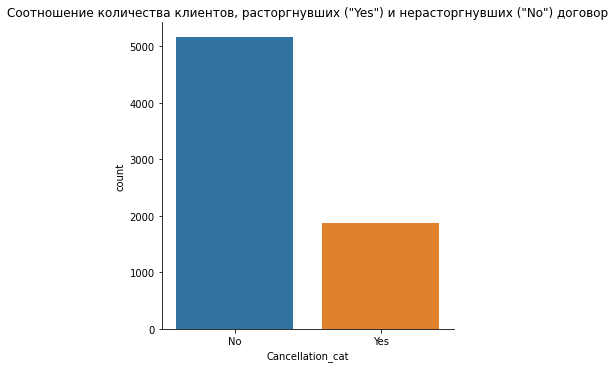

In [61]:
ax = sns.catplot(x="Cancellation_cat", data=df, kind = 'count');
plt.title('Соотношение количества клиентов, расторгнувших ("Yes") и нерасторгнувших ("No") договор');

In [62]:
df['Cancelled'].mean()

0.26578498293515357

**Вывод.** Более четверти (26,6%) всех договоров расторгнуто. С учётом ранее полученной информации о том, что расторжение договоров началось 01.10.2019, ситуация требует повышенного внимания заказчика и глубокого анализа.

Создадим функцию plot для отрисовки графиков, требующихся для анализа данных:

In [63]:
def plot(column, data, title):
    ax = sns.countplot(x=column, data=data, hue='Cancellation_cat')
    plt.title(title)

### Зависимость оттока клиентов от гендерного признака

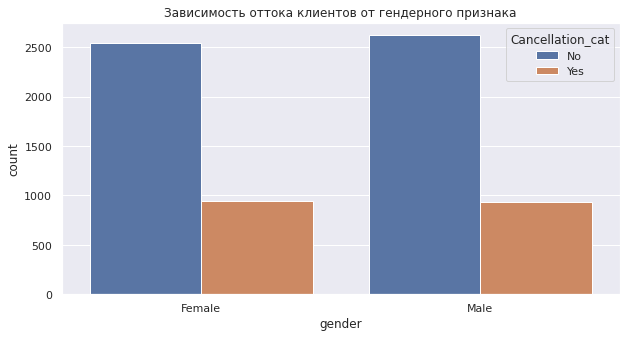

In [64]:
sns.set(rc={'figure.figsize':(10, 5)})
plot('gender', df, 'Зависимость оттока клиентов от гендерного признака');

**Вывод.** Клиенты расторгают договоры вне зависимости от пола.

### Зависимость оттока клиентов от категории "Пожилой абонент"

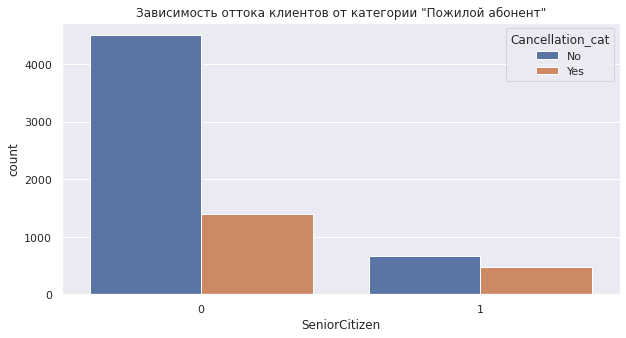

In [65]:
plot('SeniorCitizen', df, 'Зависимость оттока клиентов от категории "Пожилой абонент"');

**Вывод.** Пожилые абоненты гораздо чаще расторгают договор. Возможные причины (характерные для данной возрастной категории):
- неудобство интерфейса личного кабинета (мелкий шрифт, неинтуитивное управление и т.п.),
- неудобный способ оплаты услуг,
- непонятная информация о задолженности или о суммах, подлежащих списанию,
- высокая стоимость услуг.

### Зависимость оттока клиентов от типа оплаты

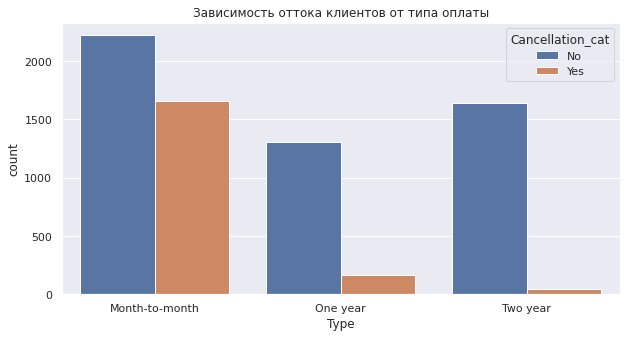

In [66]:
plot('Type', df, 'Зависимость оттока клиентов от типа оплаты');

**Вывод.** Клиенты, заключающие договор на 1-2 года, гораздо реже расторгают договор. Необходимо пересматривать условия тарифов при оплате Month-to-month для предотвращения дальнейшего оттока клиентов из этой категории.

### Зависимость оттока клиентов от наличия/типа телефонной линии

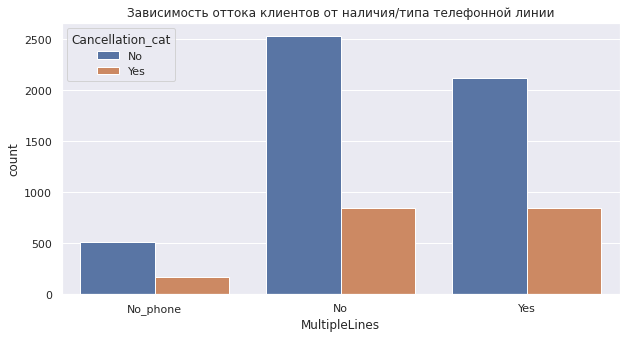

In [67]:
plot('MultipleLines', df, 'Зависимость оттока клиентов от наличия/типа телефонной линии');

**Вывод.** Наличие или отсутствие телефонной линии, а также тип подключения практически не влияют на частоту расторжения договоров.

### Зависимость оттока клиентов от наличия/типа интернет-линии

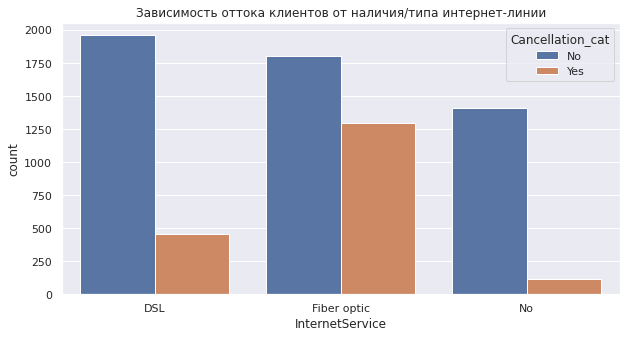

In [68]:
plot('InternetService', df, 'Зависимость оттока клиентов от наличия/типа интернет-линии');

**Вывод.** Интернет-подключение по оптоволоконному кабелю (Fiber optic) приводит к большому количеству расторгнутых договоров - требуется повышенное внимание заказчика к клиентам из данной категории. Возможно, клиентов не устраивает соотношение цена/качество.

### Зависимость оттока клиентов от метода оплаты

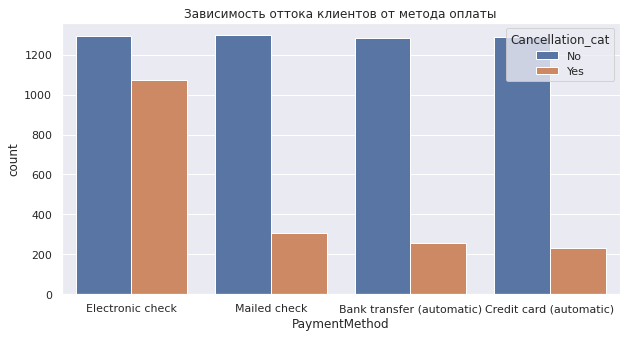

In [69]:
plot('PaymentMethod', df, 'Зависимость оттока клиентов от метода оплаты');

**Вывод.** Клиенты, получающие электронный чек, недовольны сервисом и часто расторгают договоры. Требуется внимание к качеству сервиса.

### Зависимость оттока клиентов от размера ежедневных расходов на связь и интенет

Для анализа зависимости произведём разделение клиентов на категори в зависимости от размера ежедневных расходов. Границы категорий определим по квартилям в столбце 'Charges_per_day':

In [70]:
df['Charges_per_day'].describe()

count    7032.000000
mean        2.115774
std         0.990872
min         0.437302
25%         1.175774
50%         2.288483
75%         2.943253
max         3.964316
Name: Charges_per_day, dtype: float64

Напишем функцию для разделения данных на категории и создадим для визуализации новый столбец 'Charge_cat':

In [71]:
def charge_cat(Charges_per_day):
    if Charges_per_day <1.175:
        return 'low'
    if Charges_per_day <2.288:
        return 'medium'
    if Charges_per_day <2.943:
        return 'high'
    return 'VIP'

In [72]:
df['Charge_cat'] = df['Charges_per_day'].apply(charge_cat)

In [73]:
df # проверка

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cancelled,Duration,Charges_per_day,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Cancellation_cat,Charge_cat
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,32,0.932813,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No_phone,No,low
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1037,1.822083,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,No,medium
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,62,1.744355,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes,medium
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1372,1.341655,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No_phone,No,medium
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,62,2.445968,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,Yes,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,731,2.722982,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,No,high
7028,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2192,3.358987,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,No,VIP
7029,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,338,1.025000,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No_phone,No,low
7030,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,124,2.472581,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Yes,high


Проанализируем на графике зависимость оттока клиентов от размера ежедневных расходов на связь и интенет

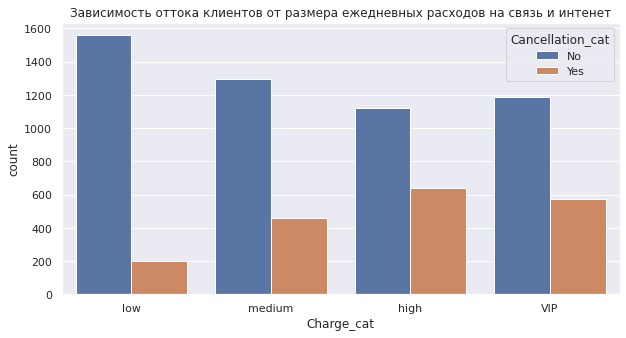

In [74]:
plot('Charge_cat', df, 'Зависимость оттока клиентов от размера ежедневных расходов на связь и интенет');

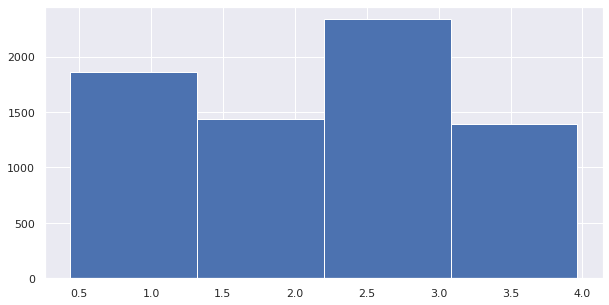

In [75]:
df['Charges_per_day'].hist(bins=4);

Для наглядности вывели рядом с графиком, характеризующим отток клиентов, распределение количества клиентов в зависимости от размера оплаты 'Charges_per_day'. Намеренно указали количество корзин bins=4.

**Вывод.** Наиболее часто расторгают договор клиенты из категории 'high', то есть клиенты, имеющие ежедневные затраты выше среднего. К тому же это - наиболее многочисленная категория клиентов. Также много расторгнутых договоров у клиентов категории 'VIP'. Возможно, клиентов с высокой стоимостью услуг не устраивает соотношение цена/качество.

## Выводы по разделу Анализ данных

Анализ данных показал серьёзные проблемы компании с оттоком клиентов:

- Более четверти (26,6%) всех договоров расторгнуто. При этом расторжение договоров началось 01.10.2019, до этой даты массового ухода клиентов не наблюдается.  


- Пожилые абоненты гораздо чаще расторгают договор. Возможные причины (характерные для данной возрастной категории): неудобство интерфейса личного кабинета (мелкий шрифт, неинтуитивное управление и т.п.), неудобный способ оплаты услуг, непонятная информация о задолженности или о суммах, подлежащих списанию, высокая стоимость услуг.  


- Клиенты, заключающие договор на 1-2 года, гораздо реже расторгают договор. Необходимо пересматривать условия тарифов при оплате Month-to-month для предотвращения дальнейшего оттока клиентов из этой категории.  


- Интернет-подключение по оптоволоконному кабелю (Fiber optic) приводит к большой доле расторгнутых договоров - требуется повышенное внимание заказчика к клиентам из данной категории. Возможно, клиентов не устраивает соотношение цена/качество.  


- Клиенты, получающие электронный чек, недовольны сервисом и часто расторгают договоры. Требуется внимание к качеству сервиса.  


- Наиболее часто расторгают договор клиенты из категории размера оплаты 'high', то есть клиенты, имеющие ежедневные затраты выше среднего. К тому же это наиболее многочисленная категория клиентов. Также много расторгнутых договоров у клиентов категории 'VIP'. Возможно, клиентов с высокой стоимостью услуг не устраивает соотношение цена/качество.  


Данные готовы к обучению моделей.



## Обучение моделей

Подготовим признаки для обучения моделей.

Разделим выборки на обучающую и тестовую.  


Обучим разноплановые модели классификации:
- Логистическая регрессия,

- CatBoostClassifier.  


Сравнить метрики качества по выполненным предсказаниям разных моделей, выберем лучшую модель.  

### Подготовка и анализ признаков 

Для того, чтобы избежать ошибок при удалении, кодировании и масштабировании признаков, будем в дальнейшем для каждой задачи создавать признаки (обучающие и целевой) из первичного датафрейма df.

Для обучающей выборки удалим стобцы:
- 'Cancelled' (целевой признак),
- 'Cancellation_cat' - дополнительный столбец, соответствующий целевому признаку,
- 'customerID' - бесполезен для обучения,
- 'BeginDate' и 'EndDate' - чтобы с одной стороны избежать утечки данных, а с другой стороны непонятна логика, объясняющая отток клиентов датами заключения/расторжения договоров. Будем обучать наши модели на персональных данных и поведенческих признаках: использование доп.услуг, размер оплаты в месяц/день и т.д.

In [76]:
features = df.drop(['Cancelled', 'customerID', 'BeginDate','EndDate', 'Cancellation_cat'], axis=1) 

In [77]:
target = df['Cancelled']

Подготовим признаки для обучения модели LogisticRegression:  
- произведем прямое кодирование категориальных признаков с помощью метода pd.get_dummies() и  
- отмасштабируем все количественные признаки с помощью StandardScaler().

In [78]:
features_lr = pd.get_dummies(features, drop_first=True)

In [79]:
features_lr

,MonthlyCharges,TotalCharges,Duration,Charges_per_day,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_No_phone,MultipleLines_Yes,Charge_cat_high,Charge_cat_low,Charge_cat_medium
0,29.85,29.85,32,0.932813,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1,56.95,1889.50,1037,1.822083,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
2,53.85,108.15,62,1.744355,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
3,42.30,1840.75,1372,1.341655,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1
4,70.70,151.65,62,2.445968,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,84.80,1990.50,731,2.722982,0,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,1,0,0
7028,103.20,7362.90,2192,3.358987,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,0,1,1,0,1,0,0,0
7029,29.60,346.45,338,1.025000,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0
7030,74.40,306.60,124,2.472581,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0


In [80]:
numeric = ['MonthlyCharges', 'TotalCharges', 'Duration', 'Charges_per_day']

scaler = StandardScaler()
scaler.fit(features_lr[numeric])

features_lr[numeric] = scaler.transform(features_lr[numeric])

In [81]:
features_lr # проверка преобразования признаков

,MonthlyCharges,TotalCharges,Duration,Charges_per_day,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_No_phone,MultipleLines_Yes,Charge_cat_high,Charge_cat_low,Charge_cat_medium
0,-1.161694,-0.994194,-1.280334,-1.193945,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1,-0.260878,-0.173740,0.064866,-0.296418,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
2,-0.363923,-0.959649,-1.240179,-0.374868,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
3,-0.747850,-0.195248,0.513266,-0.781307,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1
4,0.196178,-0.940457,-1.240179,0.333259,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.664868,-0.129180,-0.344717,0.612845,0,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,1,0,0
7028,1.276493,2.241056,1.610843,1.254755,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,0,1,1,0,1,0,0,0
7029,-1.170004,-0.854514,-0.870751,-1.100901,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0
7030,0.319168,-0.872095,-1.157192,0.360119,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0


Дополнительно проанализируем признаки на корреляцию с помощью ProfileReport():

** Примечание. Не все системы корректно поддерживают вывод интерактивных отчетов ProfileReport. Поэтому закомментим код в следующей ячейке, а для визуализации результатов исследования признаков загрузим JPG-файл (одну из страниц отчета ProfileReport).

In [82]:
#profile = ProfileReport(features_lr, title="Features Profiling Report")
#profile.to_widget()

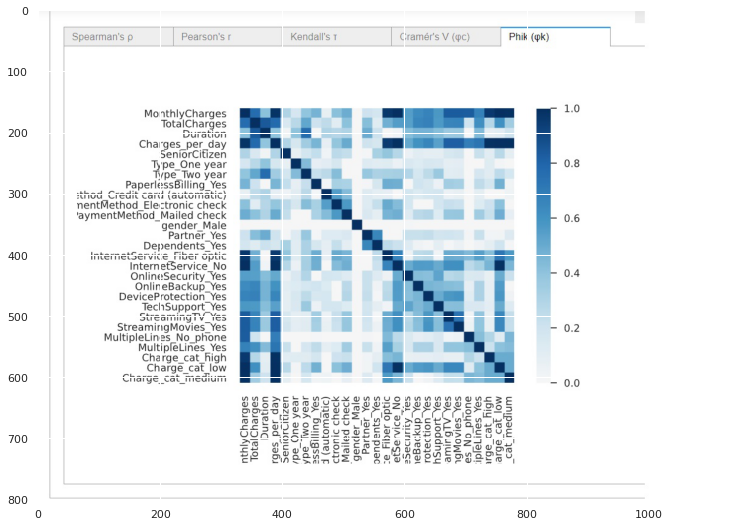

In [83]:
img = Image.open('/content/drive/My Drive/Colab Notebooks/Correlations.jpg')
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot()
ax.imshow(img)
plt.show()

Обратим внимание в отчете ProfileReport() на признаки, имеющие между собой высокую корреляцию - обстоятельство, которое может повлиять на качество обучения линейных моделей классификации.  
Во втором разделе обучения модели LogisticRegression (п. 6.3) проведём эксперимент по удалению части признаков для борьбы с мультиколлениарностью и повышения качества модели.

### Логистическая регрессия с дефолтными параметрами и на всех обучающих признаках

Первым шагом по обучению моделей проведём эксперимент с моделью Логистической регресси с дефолтными параметрами и на всех обучающих признаках.

Разделим выборку на обучающую и тестовую:

In [84]:
features_train, features_test, target_train, target_test = train_test_split(features_lr, target, 
                                                                            test_size=0.2, random_state=12345)

Обучим модель ЛР на обучающей выборке, получим предсказания на тестовой и посчитаем метрики качества AUC-ROC и Accuracy:

In [85]:
%%time
model_lr = LogisticRegression(random_state=12345)
model_lr.fit(features_train, target_train) # обучим модель

predicted_test = model_lr.predict_proba(features_test)[:, 1] # получим предсказания модели

AUC_ROC_lr = roc_auc_score(target_test, predicted_test)

print('Значение метрики AUC-ROC на тестовой выборке для модели LogisticRegression: %0.4f' % AUC_ROC_lr)
#print('F1 модели логистической регрессии: {:.4f}'.format(result_lr))

Значение метрики AUC-ROC на тестовой выборке для модели LogisticRegression: 0.8508
CPU times: user 145 ms, sys: 122 ms, total: 267 ms
Wall time: 196 ms


In [86]:
accuracy_lr = accuracy_score(target_test, model_lr.predict(features_test))
print('Значение метрики Accuracy на тестовой выборке для модели LogisticRegression: %0.4f' % accuracy_lr)

Значение метрики Accuracy на тестовой выборке для модели LogisticRegression: 0.8067


**Вывод.** Достигнуто целевое знаяение метрики по нижней допустимой границе, AUC_ROC_lr > 0.85. Проверим, можно ли улучшить качество модели, поработав с признаками.

### Логистическая регрессия - удаляем признаки

Попробуем удалить признаки с высокой корреляцией с другими:
- Charges_per_day, имеющий высокую корреляцию с MonthlyCharges,
- Charge_cat_high, Charge_cat_low, Charge_cat_medium, имеющие высокую корреляцию с MonthlyCharges

In [87]:
features_lr_drop = features_lr.drop(['Charges_per_day', 'Charge_cat_high',
                            'Charge_cat_low', 'Charge_cat_medium'], axis=1) 

In [88]:
features_lr_drop

,MonthlyCharges,TotalCharges,Duration,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_No_phone,MultipleLines_Yes
0,-1.161694,-0.994194,-1.280334,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,-0.260878,-0.173740,0.064866,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0
2,-0.363923,-0.959649,-1.240179,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0
3,-0.747850,-0.195248,0.513266,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0
4,0.196178,-0.940457,-1.240179,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.664868,-0.129180,-0.344717,0,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,0,1
7028,1.276493,2.241056,1.610843,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,0,1,1,0,1
7029,-1.170004,-0.854514,-0.870751,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0
7030,0.319168,-0.872095,-1.157192,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1


In [89]:
features_train, features_test, target_train, target_test = train_test_split(features_lr_drop, target, 
                                                                            test_size=0.2, random_state=12345)

Обучим модель ЛР на обучающей выборке, получим предсказания на тестовой и посчитаем метрики качества AUC-ROC и Accuracy:

In [90]:
model_lr = LogisticRegression(random_state=12345)#, solver='liblinear')
model_lr.fit(features_train, target_train) # обучим модель

predicted_test = model_lr.predict_proba(features_test)[:, 1] # получим предсказания модели

AUC_ROC_lr = roc_auc_score(target_test, predicted_test)

print('Значение метрики AUC-ROC на тестовой выборке для модели LogisticRegression: %0.4f' % AUC_ROC_lr)
#print('F1 модели логистической регрессии: {:.4f}'.format(result_lr))

Значение метрики AUC-ROC на тестовой выборке для модели LogisticRegression: 0.8513


In [91]:
accuracy_lr = accuracy_score(target_test, model_lr.predict(features_test))
print('Значение метрики Accuracy на тестовой выборке для модели LogisticRegression: %0.4f' % accuracy_lr)

Значение метрики Accuracy на тестовой выборке для модели LogisticRegression: 0.8067


**Вывод.** Достигнуто целевое значение метрики по нижней допустимой границе, AUC_ROC_lr > 0.85. Удаление части признаков слабо повлияло на качество модели:
- метрика AUC-ROC выросла на 0,05% (0,8513),
- метрика Accuracy не изменилась (0,8067).

### CatBoostClassifier - первый шаг

На первом шаге работы с моделью CatBoostClassifier проведём эксперимент без обработки признаков, без кросс-валидации и с моделью со следующими параметрами:

- 'eval_metric': 'AUC',
- 'loss_function': 'Logloss',
- 'learning_rate': 0.1 (данное оптимальное значение получено экспериментальным путём).

In [92]:
features = df.drop(['Cancelled', 'customerID', 'BeginDate','EndDate', 'Cancellation_cat'], axis=1) 

In [93]:
target = df['Cancelled']

Разделим выборку на обучающую и тестовую:

In [94]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=12345)

In [95]:
features_train # контроль

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Duration,Charges_per_day,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Charge_cat
1350,Month-to-month,Yes,Electronic check,19.50,178.85,277,0.645668,Female,0,No,No,No,No,No,No,No,No,No,No,low
1739,One year,Yes,Bank transfer (automatic),104.45,4162.05,1249,3.332306,Female,0,Yes,No,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,No,VIP
4192,One year,Yes,Electronic check,104.15,5743.05,1676,3.426641,Male,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,VIP
1580,One year,No,Credit card (automatic),80.45,3375.90,1280,2.637422,Male,0,Yes,No,DSL,Yes,No,No,Yes,Yes,Yes,Yes,high
3961,Two year,No,Bank transfer (automatic),20.05,1423.65,2192,0.649475,Female,0,Yes,No,No,No,No,No,No,No,No,No,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,One year,Yes,Electronic check,104.25,6860.60,2011,3.411537,Male,0,No,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Yes,VIP
3492,Month-to-month,Yes,Electronic check,75.20,3198.60,1310,2.441679,Male,0,No,No,Fiber optic,Yes,No,No,No,No,No,No,high
2177,Two year,Yes,Electronic check,103.20,5873.75,1707,3.440978,Male,0,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,VIP
3557,Month-to-month,Yes,Credit card (automatic),90.50,2595.85,915,2.836995,Male,1,No,No,Fiber optic,Yes,No,No,No,No,Yes,Yes,high


Все категориальные признаки перечислим в списке cat_features:

In [96]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Charge_cat']

Создадим словарь с параметрами модели CatBoostClassifier:

In [97]:
params = {'cat_features': cat_features,
              'eval_metric': 'AUC',
          'loss_function': 'Logloss',
              'learning_rate': 0.1,
              'random_seed': 12345,
              'verbose':50}

Создаём модель и обучаем её на обучающей выборке:

In [98]:
%%time
model = CatBoostClassifier(**params)
model.fit(features_train, target_train)

0:	total: 63ms	remaining: 1m 2s
50:	total: 659ms	remaining: 12.3s
100:	total: 1.24s	remaining: 11s
150:	total: 1.84s	remaining: 10.3s
200:	total: 2.46s	remaining: 9.77s
250:	total: 3.06s	remaining: 9.14s
300:	total: 3.69s	remaining: 8.56s
350:	total: 4.3s	remaining: 7.94s
400:	total: 4.91s	remaining: 7.34s
450:	total: 5.54s	remaining: 6.74s
500:	total: 6.21s	remaining: 6.18s
550:	total: 6.84s	remaining: 5.58s
600:	total: 7.47s	remaining: 4.96s
650:	total: 8.08s	remaining: 4.33s
700:	total: 8.7s	remaining: 3.71s
750:	total: 9.3s	remaining: 3.08s
800:	total: 9.92s	remaining: 2.46s
850:	total: 10.5s	remaining: 1.85s
900:	total: 11.2s	remaining: 1.23s
950:	total: 11.8s	remaining: 609ms
999:	total: 12.4s	remaining: 0us
CPU times: user 21.8 s, sys: 1.28 s, total: 23.1 s
Wall time: 12.6 s


Получим предсказания на тестовой выборке и посчитаем метрики качества AUC-ROC и Accuracy:

In [99]:
prediction_test_cb = model.predict_proba(features_test)[:, 1]

In [100]:
AUC_ROC_test_cb = roc_auc_score(target_test, prediction_test_cb)
print('Значение метрики AUC-ROC на тестовой выборке для модели CatBoostClassifier: %0.4f' % AUC_ROC_test_cb)

Значение метрики AUC-ROC на тестовой выборке для модели CatBoostClassifier: 0.9225


In [101]:
accuracy_test_cb = accuracy_score(target_test, model.predict(features_test))
print('Значение метрики Accuracy на тестовой выборке для модели CatBoostClassifier: %0.4f' % accuracy_test_cb)

Значение метрики Accuracy на тестовой выборке для модели CatBoostClassifier: 0.8756


**Вывод.** Получено высокое качество модели, метрики: AUC-ROC на тестовой выборке = 0.9225, Accuracy = 0.8756. В дальнейшем эксперименте проверим, можно ли ещё повысить качество модели.

### Анализ Feature importance

Создадим функцию для вывода на экран графика важности признаков и вызовем её для нашей модели:

In [102]:
def print_fi_plot(fi,indexes,mod_name):
    coef = pd.Series(fi, index = indexes)
    imp_coef = coef.sort_values()
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance for "+mod_name)
    plt.show()

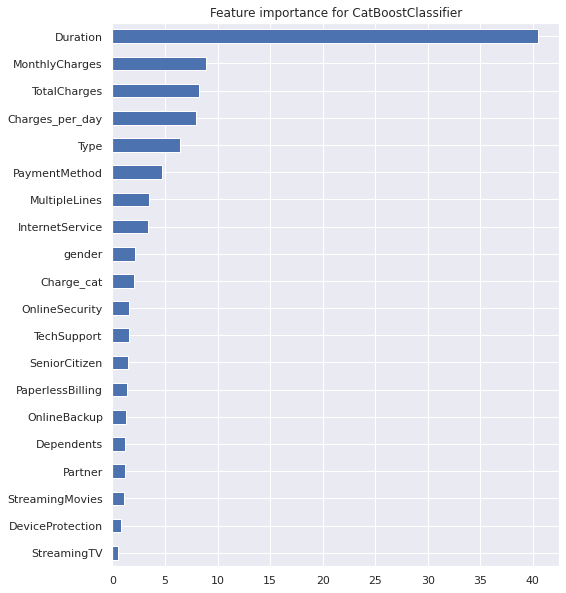

In [103]:
print_fi_plot(model.feature_importances_, features_test.columns, 'CatBoostClassifier')

**Вывод.** Присутствует большое количество признаков, слабо влияющих на качество модели. В следующем разделе проведём эксперимент: оставим только первые 8 признаков по важности и удалим остальные. Проверим как данный шаг повлияет на качество обучения.

### CatBoostClassifier с удалением части признаков

Проверим как удалелние части признаков повлияет на качество обучения модели. Удалим выбранные признаки:

In [104]:
features = df.drop(['Cancelled', 'customerID', 'BeginDate','EndDate', 'Cancellation_cat',
                   'Charge_cat', 'gender', 'Partner', 'Dependents', 'SeniorCitizen', 'PaperlessBilling', 
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                    'StreamingMovies'], axis=1) 

In [105]:
target = df['Cancelled']

In [106]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=12345)


In [107]:
features_train # контроль

,Type,PaymentMethod,MonthlyCharges,TotalCharges,Duration,Charges_per_day,InternetService,MultipleLines
1350,Month-to-month,Electronic check,19.50,178.85,277,0.645668,No,No
1739,One year,Bank transfer (automatic),104.45,4162.05,1249,3.332306,Fiber optic,No
4192,One year,Electronic check,104.15,5743.05,1676,3.426641,Fiber optic,Yes
1580,One year,Credit card (automatic),80.45,3375.90,1280,2.637422,DSL,Yes
3961,Two year,Bank transfer (automatic),20.05,1423.65,2192,0.649475,No,No
...,...,...,...,...,...,...,...,...
3497,One year,Electronic check,104.25,6860.60,2011,3.411537,Fiber optic,Yes
3492,Month-to-month,Electronic check,75.20,3198.60,1310,2.441679,Fiber optic,No
2177,Two year,Electronic check,103.20,5873.75,1707,3.440978,Fiber optic,Yes
3557,Month-to-month,Credit card (automatic),90.50,2595.85,915,2.836995,Fiber optic,Yes


In [108]:
cat_features = ['Type', 'PaymentMethod', 'InternetService', 'MultipleLines']

In [109]:
params = {'cat_features': cat_features,
              'eval_metric': 'AUC',
          'loss_function': 'Logloss',
              'learning_rate': 0.1,
              'random_seed': 12345,
              'verbose':50}

In [110]:
model = CatBoostClassifier(**params)

In [111]:
model.fit(features_train, target_train)

0:	total: 11.5ms	remaining: 11.5s
50:	total: 496ms	remaining: 9.22s
100:	total: 941ms	remaining: 8.37s
150:	total: 1.49s	remaining: 8.37s
200:	total: 2s	remaining: 7.94s
250:	total: 2.53s	remaining: 7.54s
300:	total: 3.08s	remaining: 7.15s
350:	total: 3.61s	remaining: 6.67s
400:	total: 4.13s	remaining: 6.17s
450:	total: 4.66s	remaining: 5.68s
500:	total: 5.19s	remaining: 5.17s
550:	total: 5.73s	remaining: 4.67s
600:	total: 6.25s	remaining: 4.15s
650:	total: 6.8s	remaining: 3.64s
700:	total: 7.32s	remaining: 3.12s
750:	total: 7.86s	remaining: 2.6s
800:	total: 8.38s	remaining: 2.08s
850:	total: 8.91s	remaining: 1.56s
900:	total: 9.44s	remaining: 1.04s
950:	total: 9.96s	remaining: 513ms
999:	total: 10.5s	remaining: 0us


Получим предсказания на тестовой выборке и посчитаем метрики качества AUC-ROC и Accuracy:

In [112]:
prediction_test_cb = model.predict_proba(features_test)[:, 1]

In [113]:
AUC_ROC_test_cb = roc_auc_score(target_test, prediction_test_cb)
print('Значение метрики AUC-ROC на тестовой выборке для модели CatBoostClassifier: %0.4f' % AUC_ROC_test_cb)

Значение метрики AUC-ROC на тестовой выборке для модели CatBoostClassifier: 0.9267


In [114]:
accuracy_test_cb = accuracy_score(target_test, model.predict(features_test))
print('Значение метрики Accuracy на тестовой выборке для модели CatBoostClassifier: %0.4f' % accuracy_test_cb)

Значение метрики Accuracy на тестовой выборке для модели CatBoostClassifier: 0.8778


**Вывод.** Удаление части признаков привело к небольшому росту качества: метрика AUC-ROC выросла на 0,4% (0,9267), а Accuracy - на 0,3% (0,8778). Попробуем ещё улучшить качество, применив кросс-валидацию.

### CatBoostClassifier + кросс-валидация

Попробуем с помощью кросс-валидации найти оптимальное значение итераций, чтобы избежать переобучения модели.

In [115]:
features = df.drop(['Cancelled', 'customerID', 'BeginDate','EndDate', 'Cancellation_cat',
                   'Charge_cat', 'gender', 'Partner', 'Dependents', 'SeniorCitizen', 'PaperlessBilling', 
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                    'StreamingMovies'], axis=1)

In [116]:
target = df['Cancelled']

In [117]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=12345)


In [118]:
features_train # контроль

,Type,PaymentMethod,MonthlyCharges,TotalCharges,Duration,Charges_per_day,InternetService,MultipleLines
1350,Month-to-month,Electronic check,19.50,178.85,277,0.645668,No,No
1739,One year,Bank transfer (automatic),104.45,4162.05,1249,3.332306,Fiber optic,No
4192,One year,Electronic check,104.15,5743.05,1676,3.426641,Fiber optic,Yes
1580,One year,Credit card (automatic),80.45,3375.90,1280,2.637422,DSL,Yes
3961,Two year,Bank transfer (automatic),20.05,1423.65,2192,0.649475,No,No
...,...,...,...,...,...,...,...,...
3497,One year,Electronic check,104.25,6860.60,2011,3.411537,Fiber optic,Yes
3492,Month-to-month,Electronic check,75.20,3198.60,1310,2.441679,Fiber optic,No
2177,Two year,Electronic check,103.20,5873.75,1707,3.440978,Fiber optic,Yes
3557,Month-to-month,Credit card (automatic),90.50,2595.85,915,2.836995,Fiber optic,Yes


In [119]:
cat_features = ['Type', 'PaymentMethod', 'InternetService', 'MultipleLines']

In [120]:
train_data = Pool(data=features_train,
                  label=target_train,
                  cat_features=cat_features
                 )

In [121]:
params = {'cat_features': cat_features,
              'eval_metric': 'AUC',
          'loss_function': 'Logloss',
              'learning_rate': 0.1,
              'random_seed': 12345,
              'verbose':50,
          'iterations': 1500}

Запустим кросс-валидацию со значением fold_count=5:

In [122]:
cv_data = cv(
    params = params,
    pool = train_data,
    verbose=False,
    fold_count=5,
    shuffle=True)

Training on fold [0/5]

bestTest = 0.9154710955
bestIteration = 1023

Training on fold [1/5]

bestTest = 0.9109431676
bestIteration = 1037

Training on fold [2/5]

bestTest = 0.9149994307
bestIteration = 574

Training on fold [3/5]

bestTest = 0.9158228826
bestIteration = 1315

Training on fold [4/5]

bestTest = 0.8999059519
bestIteration = 1467



In [123]:
cv_data

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.813842,0.030544,0.628571,0.008098,0.627437,0.006615
1,1,0.824904,0.021525,0.581622,0.010334,0.579750,0.008305
2,2,0.831030,0.012260,0.544852,0.006100,0.542629,0.004020
3,3,0.834130,0.012242,0.516768,0.006530,0.514319,0.001107
4,4,0.836590,0.011326,0.495330,0.006844,0.492545,0.001148
...,...,...,...,...,...,...,...
1495,1495,0.909902,0.006228,0.328370,0.017357,0.082558,0.001790
1496,1496,0.909893,0.006215,0.328414,0.017318,0.082511,0.001807
1497,1497,0.909894,0.006205,0.328385,0.017176,0.082453,0.001808
1498,1498,0.909928,0.006226,0.328347,0.017266,0.082376,0.001805


Найдем итерацию, на которой test-AUC-mean максимальна:

In [124]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
1314,1314,0.910499,0.006785,0.324988,0.017185,0.093668,0.001859


Запустим обучение модели со значением iterations=1154:

In [125]:
params = {'cat_features': cat_features,
              'eval_metric': 'AUC',
          'loss_function': 'Logloss',
              'learning_rate': 0.1,
              'random_seed': 12345,
              'verbose':100,
          'iterations': 1154}

In [126]:
model = CatBoostClassifier(**params)

In [127]:
model.fit(train_data)

0:	total: 11.3ms	remaining: 13.1s
100:	total: 963ms	remaining: 10s
200:	total: 2.01s	remaining: 9.52s
300:	total: 3.07s	remaining: 8.69s
400:	total: 4.12s	remaining: 7.74s
500:	total: 5.19s	remaining: 6.76s
600:	total: 6.26s	remaining: 5.76s
700:	total: 7.32s	remaining: 4.73s
800:	total: 8.39s	remaining: 3.7s
900:	total: 9.45s	remaining: 2.65s
1000:	total: 10.5s	remaining: 1.61s
1100:	total: 11.6s	remaining: 557ms
1153:	total: 12.2s	remaining: 0us


Получим предсказания на тестовой выборке и посчитаем метрики качества AUC-ROC и Accuracy:

In [128]:
prediction_test_cb = model.predict_proba(features_test)[:, 1]

In [129]:
AUC_ROC_test_cb = roc_auc_score(target_test, prediction_test_cb)
print('Значение метрики AUC-ROC на тестовой выборке для модели CatBoostClassifier: %0.4f' % AUC_ROC_test_cb)

Значение метрики AUC-ROC на тестовой выборке для модели CatBoostClassifier: 0.9265


In [130]:
accuracy_test_cb = accuracy_score(target_test, model.predict(features_test))
print('Значение метрики Accuracy на тестовой выборке для модели CatBoostClassifier: %0.4f' % accuracy_test_cb)

Значение метрики Accuracy на тестовой выборке для модели CatBoostClassifier: 0.8785


**Вывод.** На данном шаге не удалось улучшить целевую метрику: AUC-ROC не изменилась (0,9265), однако метрика Accuracy чуть выросла - на 0,07% (0,8785).

На этом эксперименты с моделью CatBoostClassifier можно считать законченными.

### ROC-кривая

Визуализируем ROC-кривую для конечного состояния лучшей модели CatBoostClassifier:

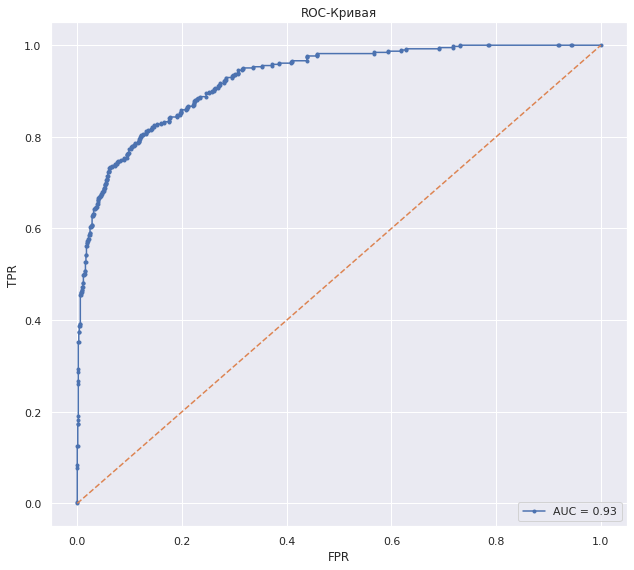

In [131]:
ax1 = plt.subplot2grid((1,2), (0,0))
fpr, tpr, thresholds = roc_curve(target_test, prediction_test_cb)
ax1.plot(fpr, tpr, marker ='.', label = 'AUC = %0.2f' % AUC_ROC_test_cb)
ax1.legend(loc = 'lower right')

ax1.plot([0,1],[0,1],linestyle = "--")
        
ax1.set_xlabel('FPR')
ax1.set_ylabel('TPR')
ax1.set_title('ROC-Кривая')
            
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.1, right=2.5, hspace=1, wspace=0.4)
plt.show()

Изменяя порог отсечения на данной кривой, заказчик может получить возрастающие значения как истинно положительных, так и ложно положительных решений. При этом заказчик должен сам определить насколько для его бизнеса отрицательное влияние ложно положительных решений (клиенту выдали промокод на скидку из-за прогнозируемого ухода, а он не собирался уходить) весомее, чем влияние истинно положительных (клиент ушёл).

## Общий вывод

В результате выполнения проекта были выявлены возможные причины оттока клиентов Оператора связи «Ниединогоразрыва.ком», а также обучена модель, предсказывающая уход клиентов.

Среди основных возможных причин ухода клиентов рассмотрены:

- Пожилые абоненты гораздо чаще расторгают договор. Возможно, клиентам данной возрастной категории не нравится неудобство интерфейса, неинтуитивное управление личным кабинетом, неудобный способ оплаты услуг, непонятная информация о задолженности или о суммах, подлежащих списанию, высокая стоимость услуг.  

- Клиенты, заключающие договор на 1-2 года, гораздо реже расторгают договор. Необходимо пересматривать условия тарифов при оплате Month-to-month для предотвращения дальнейшего оттока клиентов из этой категории.  

- Интернет-подключение по оптоволоконному кабелю (Fiber optic) приводит к большой доле расторгнутых договоров - возможно, клиентов не устраивает соотношение цена/качество.  

- Клиенты, получающие электронный чек, недовольны сервисом и часто расторгают договоры - требуется внимание к качеству сервиса.  

- Наиболее часто расторгают договор клиенты из категорий размера оплаты 'high' и 'VIP', то есть клиенты, имеющие ежедневные затраты выше среднего - возможно, клиентов с высокой стоимостью услуг не устраивает соотношение цена/качество. 

- В результате: более четверти (26,6%) всех договоров расторгнуто. При этом расторжение договоров началось 01.10.2019, до этой даты массового ухода клиентов не наблюдалось. Более трети (33,7%) всех новых, заключенных с ноября 2019 года договоров расторгнуто.  


Обучена модель CatBoostClassifier, предсказывающая отток клиентов. Получены достаточно высокие значения целевых метрик:
- AUC-ROC = 0,9271, 
- Accuracy = 0,8785.

Модель LogisticRegression показала качество хуже, чем CatBoostClassifier:
- AUC-ROC = 0,8513,
- Accuracy = 0,8067,  
однако целевое значение метрики (0,85) было достигнуто, а скорость обучения и предсказания у Логистической регрессии (около 1,5 секунд) лучше, чем у CatBoostClassifier (около 18 секунд без кросс-валидации), из чего можно допустить применение данной модели на датафреймах большого объёма.  

**Примечание. Данные по скорости обучения могут меняться в зависимости от вычислительных мощностей, но соотношения сохраняются.